# Convolutional Autoencoder

In [52]:
# Author: Vivian Wong
# Modified from Code by Sherlock Liao available at https://github.com/L1aoXingyu/pytorch-beginner?files=1

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [53]:
def load_meltpool_dataset():
    # 56x56. modify CNN to match when loading
    root = './data/meltpool/Meltpool_Camera_(partial)_processed'
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(56),
#         transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset, dataloader

def load_MNIST_dataset():
    # 28x28. modify CNN to match when loading.
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = MNIST('./data', transform=transform, download=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader

In [54]:
# autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
#             nn.Tanh()
#         )
        # for 56x56
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 6, stride=6, padding=2),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=4, padding=2),  # b, 1, 56, 56
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [65]:
# autoencoder
import torch.nn.functional as F

from unet_parts import *


class autoencoder(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(autoencoder, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        encoded = self.down4(x4)
        x = self.up1(encoded, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        decoded = self.outc(x)
        return encoded, decoded

In [66]:
if not os.path.exists('./conv_img'):
    os.mkdir('./conv_img')
    
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 56, 56)
    return x

num_epochs = 30
learning_rate = 1e-3

dataset, dataloader = load_meltpool_dataset()
# dataset, dataloader = load_MNIST_dataset()

using device: cpu


In [67]:
dataset

Dataset ImageFolder
    Number of datapoints: 62609
    Root location: ./data/meltpool/Meltpool_Camera_(partial)_processed
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(56, 56))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [57]:
def plot2D_with_labels(XY, labels, num_labels=9):
    if type(XY)==torch.Tensor:
        XY = XY.numpy()
    plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / num_labels)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)

In [58]:
def plot3D_with_labels(XYZ, labels, num_labels=9):
    if type(XYZ)==torch.Tensor:
        XYZ = XYZ.numpy()
    fig = plt.figure(2); ax = Axes3D(fig)
    X, Y, Z = XYZ[:, 0].numpy(), XYZ[:, 1].numpy(), XYZ[:, 2].numpy() # put encoded data to [x,y,z]
    digits = train_data.train_labels[:200].numpy()
    for x, y, z, s in zip(X, Y, Z, digits):
        c = cm.rainbow(int(255*s/num_labels)); ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
    plt.show()

In [59]:
def plot2D_with_thumbnails(XY, labels, thumbnails, num_labels = 9, cmap = None):
    def getThumbnail(path):
        return OffsetImage(plt.imread(path), zoom=0.5, cmap=cmap)

    if type(XY)==torch.Tensor:
        XY = XY.numpy()
#     plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(X, Y) 
    for x, y, s, path in zip(X, Y, labels, thumbnails):
        ab = AnnotationBbox(getThumbnail(path), (x, y), frameon=True)
        ax.add_artist(ab)
        
#         c = cm.rainbow(int(255 * s / num_labels))
#         plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#         plt.scatter(x, y, marker=path)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)
    
  

In [68]:
# train autoencoder
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
#         img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        encoded, decoded = model(img)
        loss = criterion(decoded, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(decoded.cpu().data)
        save_image(pic, './conv_img/image_{}.png'.format(epoch))
        torch.save(model.state_dict(), './conv_autoencoder_unet.pth')

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './conv_autoencoder_unet.pth')

## View encoder output in 2D

In [122]:
# optional - load model state dict
model = autoencoder().to(device)
model.load_state_dict(torch.load('./conv_autoencoder.pth'))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

### Meltpool

torch.Size([200, 8, 2, 2])


/Users/vivianwong/anaconda3/envs/autoencoder/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  
/Users/vivianwong/anaconda3/envs/autoencoder/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  


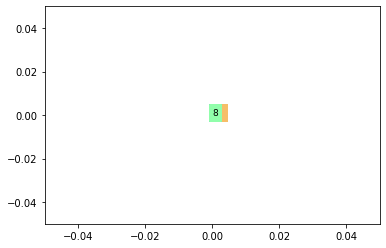

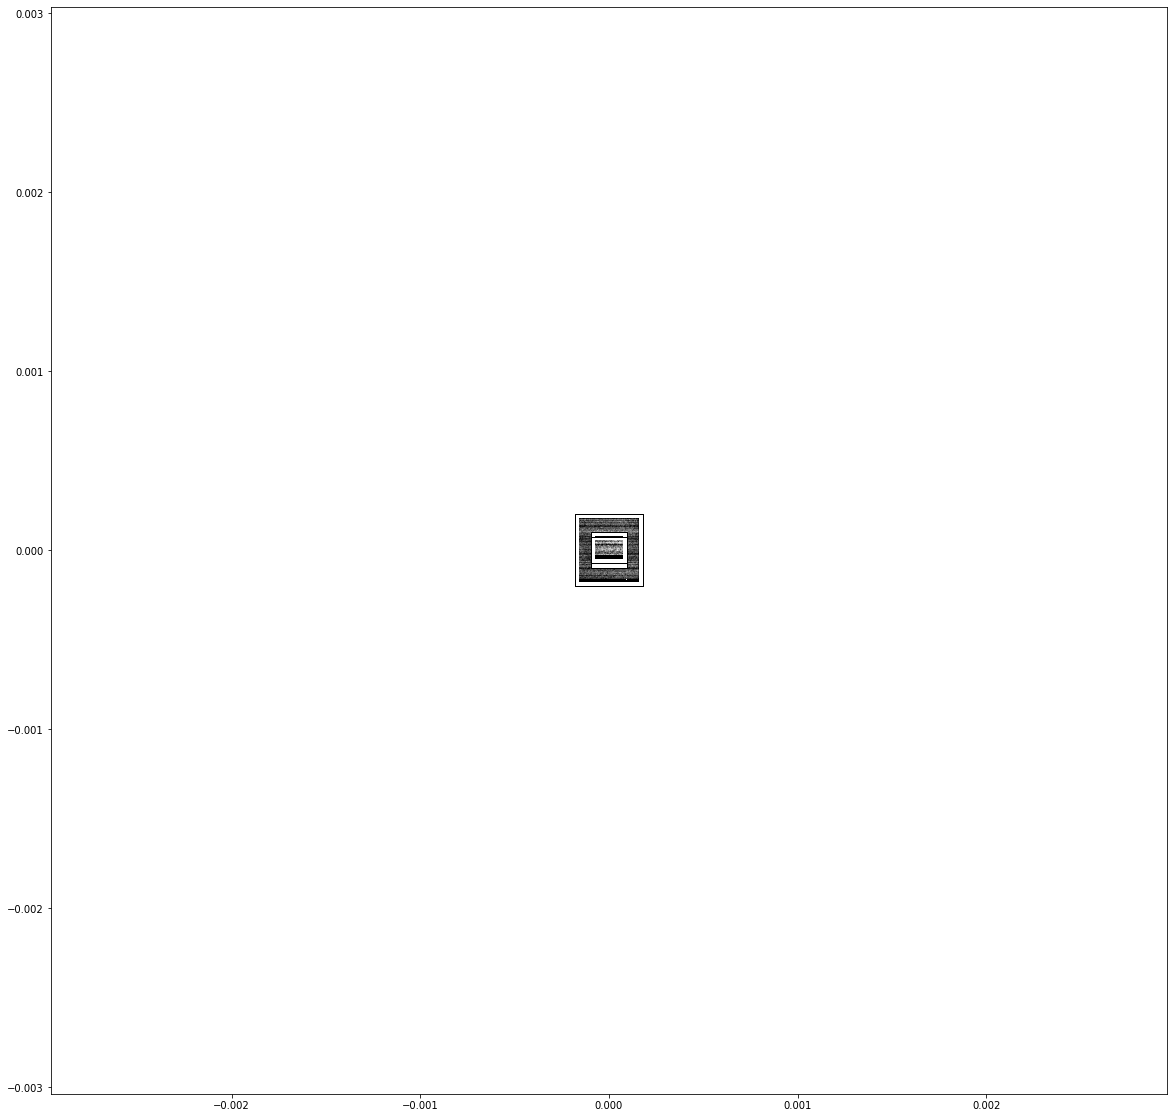

In [62]:
num_viewed = 200
random_seed = 1
indices = list(range(len(dataset)))
np.random.seed(random_seed)
np.random.shuffle(indices)
view_indices = indices[:num_viewed]
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 1, 56, 56)
view_data_layers = np.random.randint(1, size=num_viewed)

view_thumbnails = [dataset.imgs[i][0] for i in view_indices]
for i in range(num_viewed):
    view_data[i,:,:,:] = dataset[view_indices[i]][0]
    view_data_layers[i] = int(dataset[view_indices[i]][1])
    
encoded_data, _ = model(view_data)
print(encoded_data.shape)
# # view encoder output in 2D
plot2D_with_labels(encoded_data.data.view(encoded_data.shape[0],-1), view_data_layers, num_labels = 15)
plot2D_with_thumbnails(encoded_data.data.view(encoded_data.shape[0],-1), view_data_layers, view_thumbnails, num_labels = 15, cmap = 'gray')

#### View encoder output using T-SNE

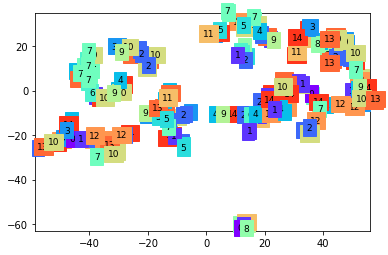

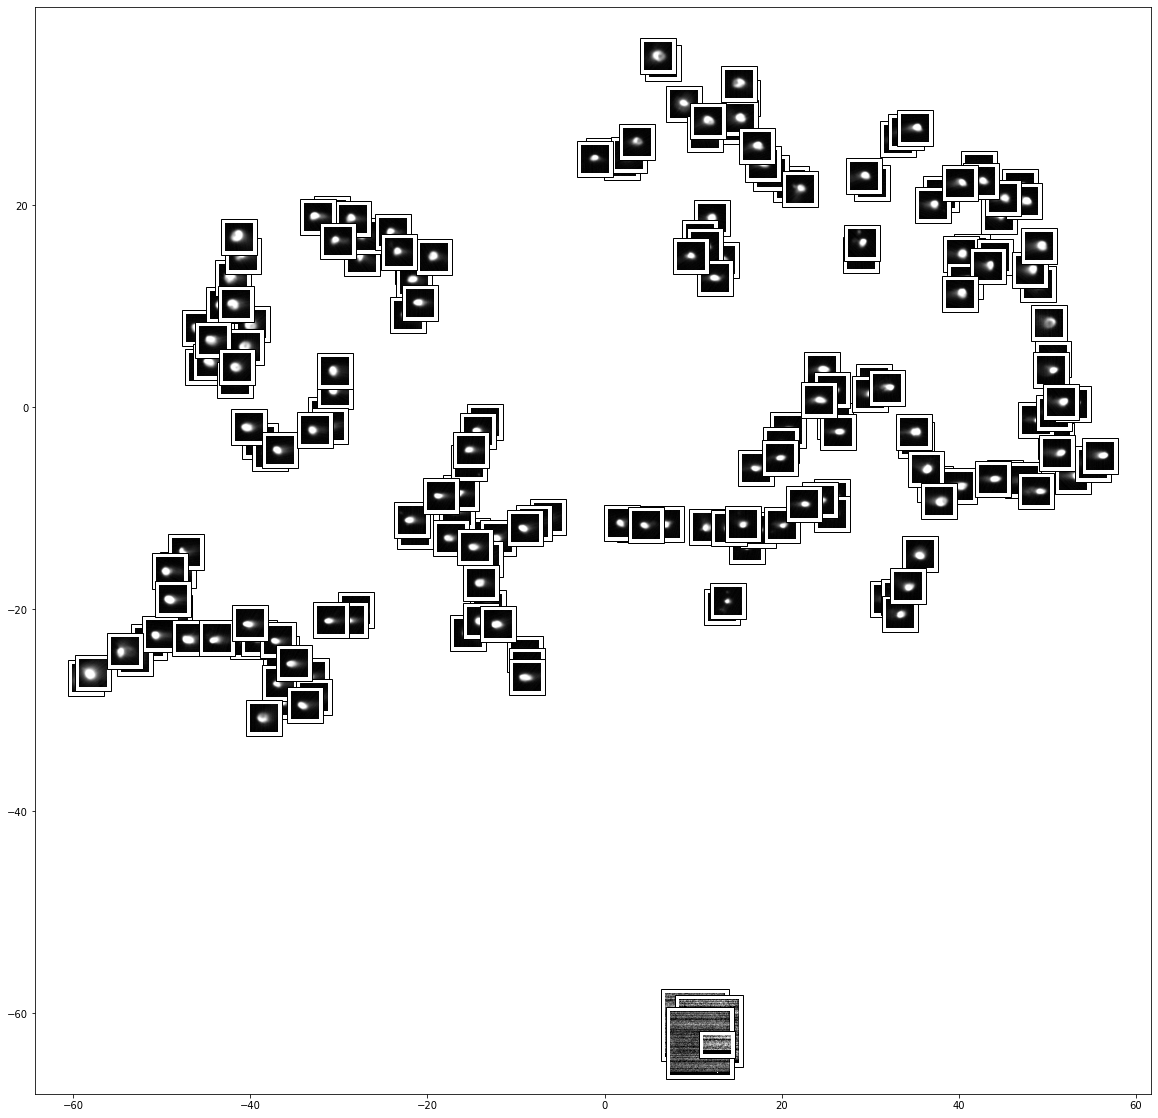

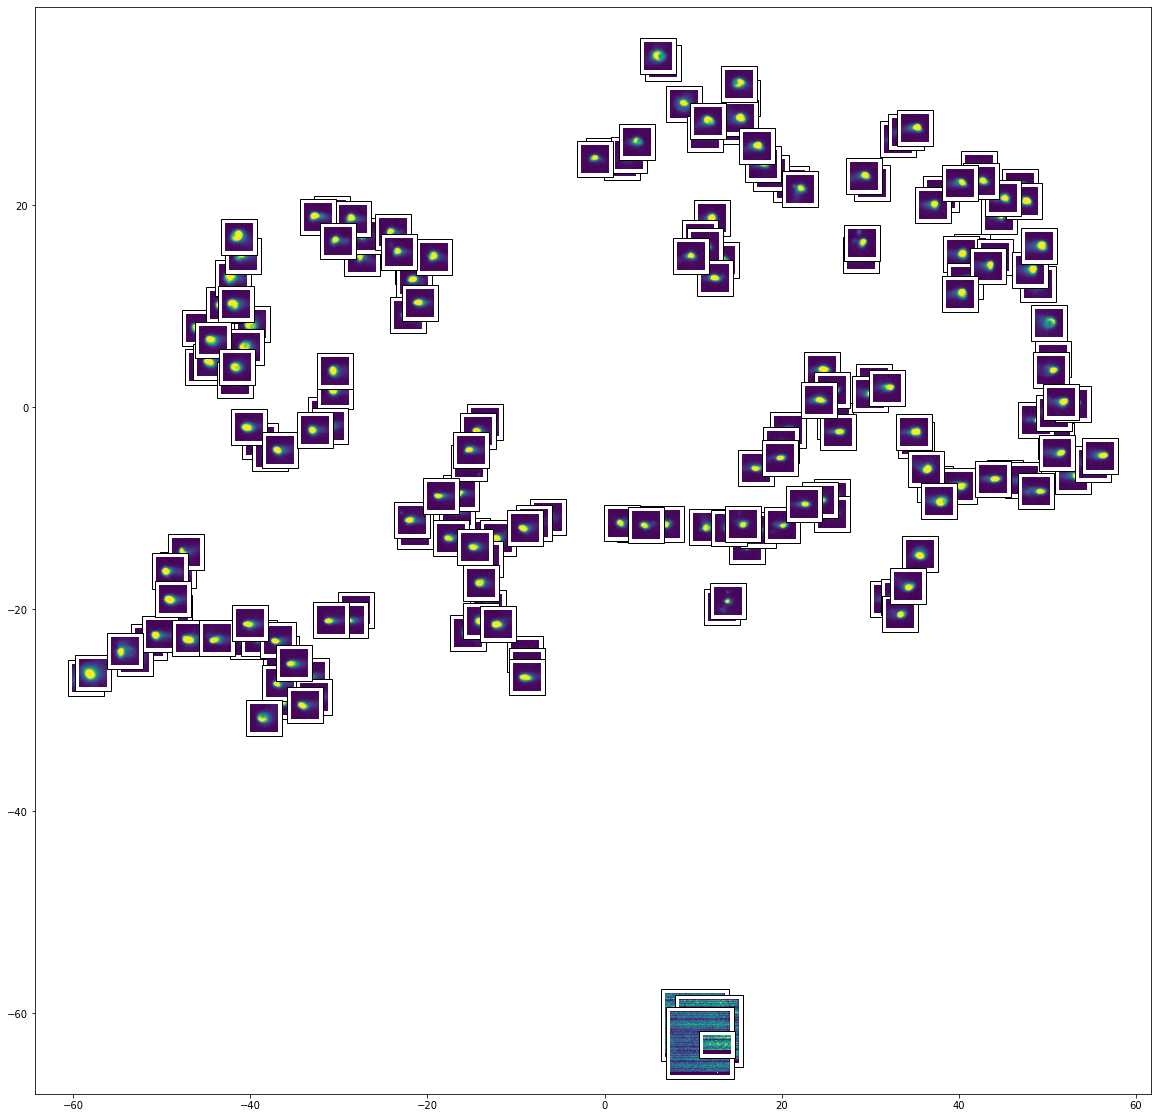

In [63]:
X = encoded_data.data.view(num_viewed,-1).numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, view_data_layers, num_labels = 15)
plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15, cmap='gray')

plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15)

### MNIST

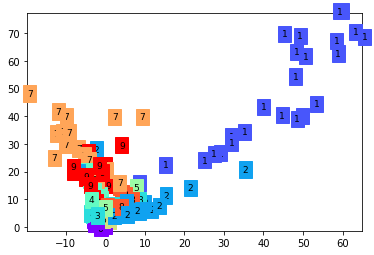

In [121]:
num_viewed = 200
view_indices = list(range(len(dataset)))
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
digits = np.random.randint(1, size=num_viewed)

for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    digits[i] = dataset[view_indices[i]][1]
    
encoded_data, _ = model(view_data)
plot2D_with_labels(encoded_data.data, digits)

# # alternate way to do the above
# view_data = dataset.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255. # flatten each image to vector then normalize so max is max 1. 
# encoded_data, _ = model(view_data)

# digits = dataset.targets[:200].numpy()
# # view encoder output in 2D
# plot2D_with_labels(encoded_data.data, digits)

#### View encoder output using T-SNE

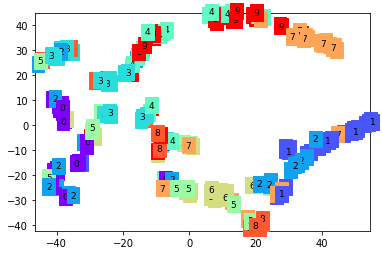

In [44]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, digits)